In [1]:
!nvidia-smi

Sat Apr 12 12:42:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 🔵 **Dependencies**

In [ ]:
!pip install -q transformers datasets

In [ ]:
!pip install -q torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.17.0 --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip install -q numpy==2.2.0

# 🔵 **Import Libraries**

In [39]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors, decoders
from transformers import AutoTokenizer
from datasets import load_dataset
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns
from scipy import stats
from scipy.stats import lognorm, pareto
import time

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

# 🔵 **TinyStories Dataset**

## 🔵 **LoadDataset**

In [3]:
dataset = load_dataset("roneneldan/TinyStories")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [4]:
train_dataset = dataset['train']
valid_dataset = dataset['validation']
print('Number of train rows(stories): ', train_dataset.num_rows/1e6, 'Million rows(stories)')
print('Number of valid rows(stories): ', valid_dataset.num_rows/1e6, 'Million rows(stories)')

Number of train rows(stories):  2.119719 Million rows(stories)
Number of valid rows(stories):  0.02199 Million rows(stories)


In [5]:
[print(f'story{i+1}: \n\n', train_dataset[i]['text'], '\n') for i in range(5)]

story1: 

 One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together. 

story2: 

 Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had many lea

[None, None, None, None, None]

## 🔵 **EDA(Exploratory Data Analysis)**

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
num_tok  = 0
num_char = 0
char_counts  = Counter()
token_counts = Counter()
batch = 512
dataset_size = len(train_dataset['text'])

with tqdm(range(dataset_size // batch + 1), desc="📊 Processing batches") as tep:
    for i in tep:
        batch_texts = train_dataset[i * batch : (i + 1) * batch]['text']
        text = " ".join(batch_texts)
        num_char += len(text)
        char_counts.update(text)
        tokenized = tokenizer(text)
        num_tok += len(tokenized)
        token_counts.update(tokenized)
        tep.set_postfix(
            unique_tokens=len(token_counts),
            total_tokens=num_tok,
            total_chars=num_char,
            unique_chars=len(char_counts),
            most_common_char=char_counts.most_common(1)[0][0])

📊 Processing batches: 100%|██████████| 4141/4141 [07:28<00:00,  9.23it/s, most_common_char=, total_chars=1.9e+9, total_tokens=4.39e+8, unique_chars=174, unique_tokens=63577]


### 🔵 **Character Level**

In [ ]:
num_char

1902088781

In [ ]:
df_count_ch = pd.DataFrame.from_dict(char_counts, orient='index', columns=['count'])

In [ ]:
df_count_ch.describe()

,count
count,1.740000e+02
mean,1.093154e+07
std,3.733032e+07
min,1.000000e+00
25%,1.025000e+01
50%,3.745000e+02
75%,1.213577e+06
max,3.642332e+08


In [ ]:
df_count_ch[df_count_ch['count']==1]

,count
|,1
Ñ,1
ƒ,1
µ,1
®,1
î,1
Ò,1


In [ ]:
df_count_ch[df_count_ch['count']>1.093154e+07].shape, df_count_ch[df_count_ch['count']<1.093154e+07].shape

((27, 1), (147, 1))

In [ ]:
df_count_ch.sort_values('count', ascending=False).head(10)

,count
,364233176
e,180782399
a,127963378
t,118625067
o,99438049
h,93158669
n,88723326
i,81541616
d,81365133
s,78717020


In [ ]:
df_count_ch.sort_values('count', ascending=False).tail(10)

,count
š,2
@,2
É,2
|,1
Ñ,1
ƒ,1
î,1
®,1
µ,1
Ò,1


In [ ]:
364233176/num_char # Space character

0.19149115416605783

In [ ]:
df_count_ch[df_count_ch['count'] == 1].shape, df_count_ch[df_count_ch['count'] == 2].shape, df_count_ch[df_count_ch['count'] == 3].shape

((7, 1), (4, 1), (2, 1))

In [ ]:
df_count_ch[df_count_ch['count'] > 3].shape

(161, 1)

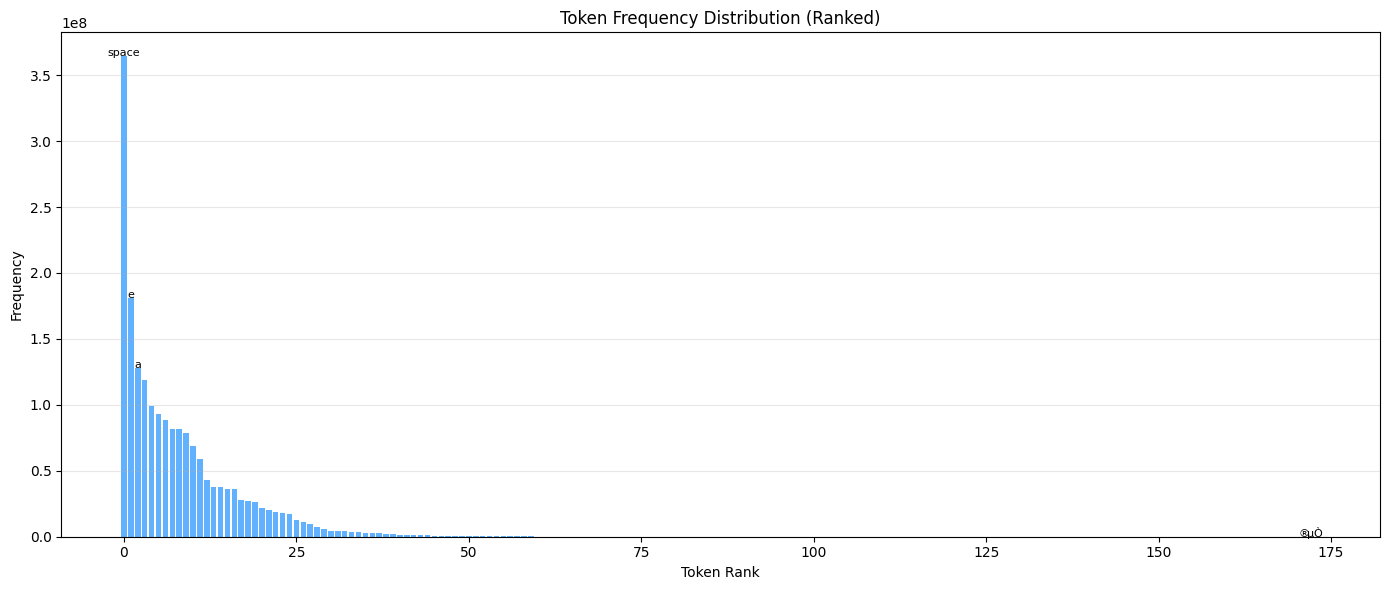

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_sorted = df_count_ch.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(range(len(df_sorted)), df_sorted['count'],
        color='dodgerblue', alpha=0.7, width=0.8)

plt.title('Token Frequency Distribution (Ranked)')
plt.xlabel('Token Rank')
plt.ylabel('Frequency')
for rank in [0, 1, 2, -3, -2, -1]:
    token = df_sorted.index[rank]
    plt.text(range(df_sorted.shape[0])[rank], df_sorted['count'].iloc[rank], token  if rank!=0 else "space", ha='center', fontsize=8)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df_sorted.iloc[:50].sum()/num_char

,0
count,0.998122


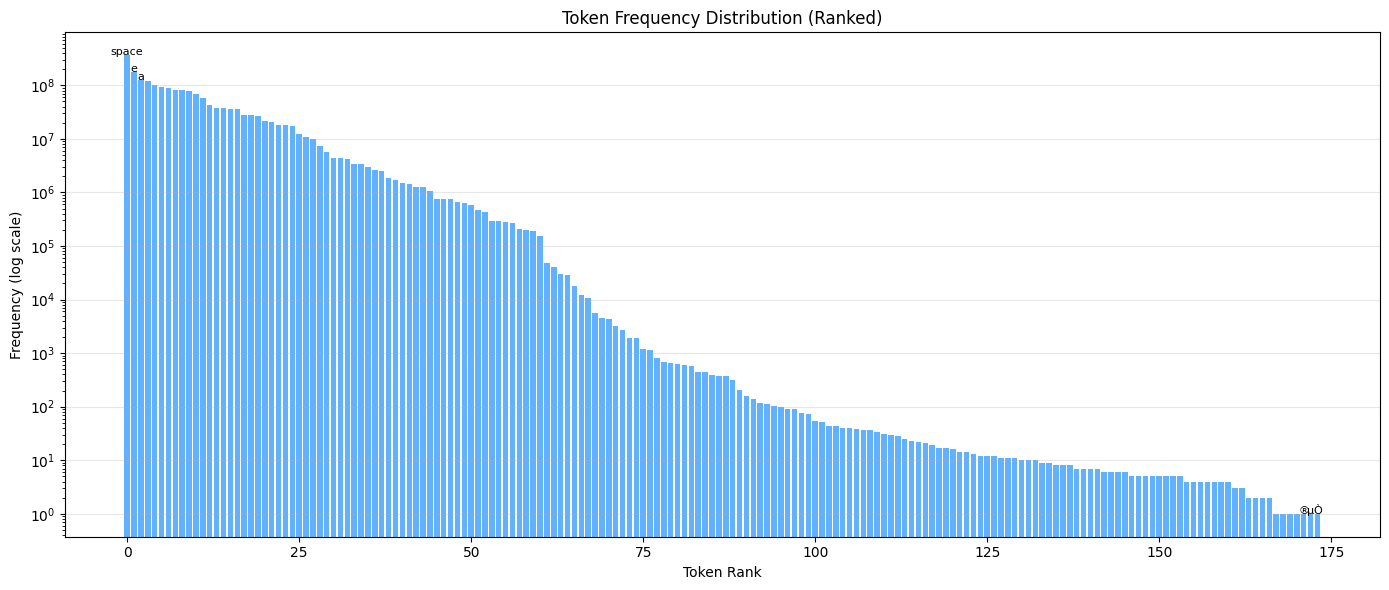

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_sorted = df_count_ch.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(range(len(df_sorted)), df_sorted['count'],
        color='dodgerblue', alpha=0.7, width=0.8)

plt.yscale('log')
plt.title('Token Frequency Distribution (Ranked)')
plt.xlabel('Token Rank')
plt.ylabel('Frequency (log scale)')
for rank in [0, 1, 2, -3, -2, -1]:
    token = df_sorted.index[rank]
    plt.text(range(df_sorted.shape[0])[rank], df_sorted['count'].iloc[rank], token  if rank!=0 else "space", ha='center', fontsize=8)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

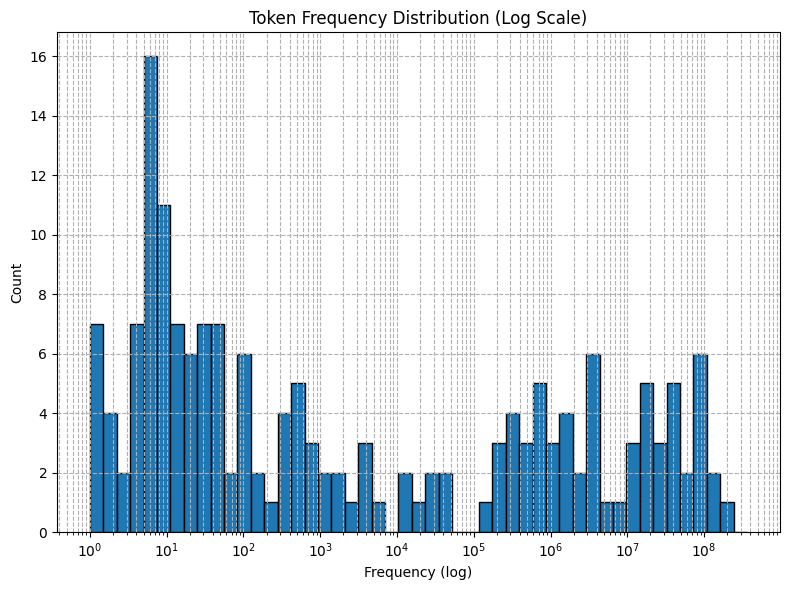

In [ ]:
def gini_coefficient(array):
    array = np.array(array, dtype=np.float64)
    if np.any(array < 0):
        array -= np.amin(array)
    array += np.finfo(float).eps
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n+1)
    return float((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


plt.figure(figsize=(8, 6))
if len(df_count_ch) > 0:
    bins = np.logspace(np.log10(df_count_ch['count'].min()),
                     np.log10(df_count_ch['count'].max()),
                     50)
    plt.hist(df_count_ch['count'], bins=bins, edgecolor='black')
    plt.xscale('log')
    plt.title('Token Frequency Distribution (Log Scale)')
    plt.xlabel('Frequency (log)')
    plt.ylabel('Count')
    plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

### 🔵 **Word Level**

In [ ]:
df_count = pd.DataFrame.from_dict(token_counts, orient='index', columns=['count'])

In [ ]:
print('Number of characters in train part: ', num_char/1e9, 'Billion characters')
print('Number of tokens in train part: ', num_tok/1e6, 'Million tokens')
print('Number of unique tokens in train part: ', len(token_counts), 'tokens')
print('Number of unique character in train part: ', len(char_counts), 'characters')
print(f'On average, there are {num_char//dataset_size} characters in each story.: ')
print(f'On average, there are {num_tok//dataset_size} tokens in each story.')
print(f"The most common token is '{df_count[df_count['count'] == df_count['count'].values.max()].index.tolist()[0]}' \
with {df_count['count'].values.max()/1e6} million occurrences.")
des = df_count.describe()
print(f"The mean token repetition count is {int(des['count']['mean'])}.")
print(f"The standard deviation of token repetition is {int(des['count']['std'])}.")
print(f"The minimum token repetition count is {int(des['count']['min'])}.")
print(f"The 25th percentile of token repetition is {int(des['count']['25%'])}.")
print(f"The median token repetition count is {int(des['count']['50%'])}.")
print(f"The 75th percentile of token repetition is {int(des['count']['75%'])}.")
print(f"The maximum token repetition count is {int(des['count']['max'])}.")


print("\n\033[1m" + "📊 Text Dataset Statistics" + "\033[0m" + "\n" + "-"*50)
print(f"\033[1m• Characters:\033[0m {num_char/1e9:.2f} Billion")
print(f"\033[1m• Tokens:\033[0m {num_tok/1e6:.2f} Million")
print(f"\033[1m• Unique Tokens:\033[0m {len(token_counts):,}")
print("\n\033[1m📝 Per-Story Averages:\033[0m")
print(f"  → Characters: {num_char//dataset_size:,}")
print(f"  → Tokens: {num_tok//dataset_size:,}")
most_common_token = df_count[df_count['count'] == df_count['count'].max()].index[0]
print(f"\n\033[1m🏆 Most Frequent Token:\033[0m")
print(f"  → '{most_common_token}' ({df_count['count'].max()/1e6:.2f} million occurrences)")
print("\n\033[1m📈 Token Repetition Statistics:\033[0m")
print(f"  → Mean: {int(des['count']['mean'])}")
print(f"  → Std Dev: {int(des['count']['std']):,}")
print(f"  → Min: {int(des['count']['min']):,}")
print(f"  → 25th Percentile: {int(des['count']['25%']):,}")
print(f"  → Median: {int(des['count']['50%']):,}")
print(f"  → 75th Percentile: {int(des['count']['75%']):,}")
print(f"  → Max: {int(des['count']['max']):,}")
print("-"*50)

Number of characters in train part:  1.902088781 Billion characters
Number of tokens in train part:  439.039906 Million tokens
Number of unique tokens in train part:  63577 tokens
Number of unique character in train part:  174 characters
On average, there are 897 characters in each story.: 
On average, there are 207 tokens in each story.
The most common token is '.' with 36.459483 million occurrences.
The mean token repetition count is 6905.
The standard deviation of token repetition is 226804.
The minimum token repetition count is 1.
The 25th percentile of token repetition is 1.
The median token repetition count is 3.
The 75th percentile of token repetition is 24.
The maximum token repetition count is 36459483.

📊 Text Dataset Statistics
--------------------------------------------------
• Characters: 1.90 Billion
• Tokens: 439.04 Million
• Unique Tokens: 63,577

📝 Per-Story Averages:
  → Characters: 897
  → Tokens: 207

🏆 Most Frequent Token:
  → '.' (36.46 million occurrences)

📈 To

In [ ]:
df_count[df_count['count']==1]

,count
meow-peat,1
scourging,1
awely,1
bondâ€”,1
scariness,1
...,...
musicianship,1
shuck,1
cannibal,1
becase,1


In [ ]:
df_count[df_count['count']==1].shape[0]/(num_tok)*100

0.00451758478647269

In [ ]:
df_count[df_count['count']==1].shape[0]/df_count.shape[0]

0.3119681645878226

In [ ]:
df_count[df_count['count']>6905].shape[0]/df_count.shape[0]

0.04294005693883008


🔝 Top 10 Tokens


,count
.,"36,459,483"
the,"20,239,799"
and,"18,112,895"
",","17,359,980"
to,"12,648,384"
a,"11,475,893"
was,"9,436,658"
he,"7,977,807"
she,"7,710,551"
it,"7,104,640"


<Figure size 1200x600 with 0 Axes>

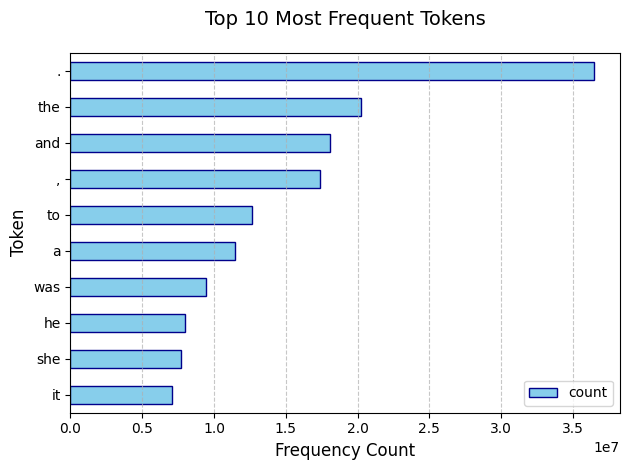

In [ ]:
print("\n🔝 Top 10 Tokens")
top_10 = df_count.sort_values('count', ascending=False).head(10)
display(top_10.style.format({'count': '{:,}'}).background_gradient(cmap='Blues'))

plt.figure(figsize=(12, 6))
top_10.plot(kind='barh', color='skyblue', edgecolor='darkblue')
plt.title('Top 10 Most Frequent Tokens', fontsize=14, pad=20)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Token', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_count[df_count.index == '.']['count']/num_tok

,count
.,0.083044


In [ ]:
top_10.sum()/num_tok

,0
count,0.338297


In [ ]:
df_count.sort_values('count', ascending=False).head(35).sum()/num_tok

,0
count,0.505558



🔝 Least Frequent 10 Tokens


,count
sealâ€,1
sourceâ€”two,1
print-job,1
harmonising,1
deperate,1
dog-toed,1
jumpt,1
robot-shield,1
leis,1
thenâ€¦he,1


<Figure size 1200x600 with 0 Axes>

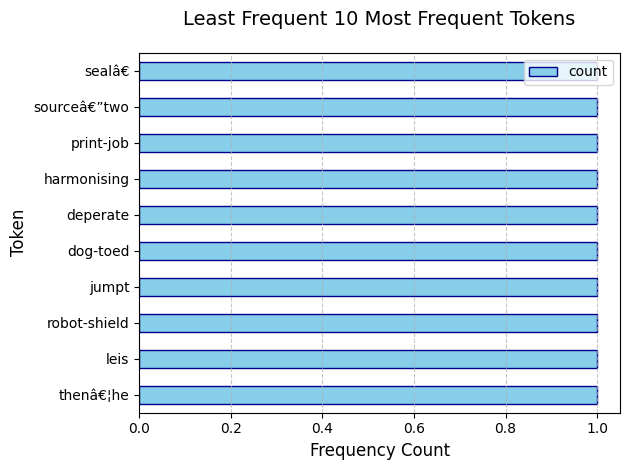

In [ ]:
print("\n🔝 Least Frequent 10 Tokens")
bottom_10 = df_count.sort_values('count', ascending=False).tail(10)
display(bottom_10.style.format({'count': '{:,}'}).background_gradient(cmap='Blues'))

plt.figure(figsize=(12, 6))
bottom_10.plot(kind='barh', color='skyblue', edgecolor='darkblue')
plt.title('Least Frequent 10 Most Frequent Tokens', fontsize=14, pad=20)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Token', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
num_spaces = df_count_ch[df_count_ch.index == ' '].values.item()
num_spaces/(df_count.sum().values.item() + num_spaces)

0.4534363022511938

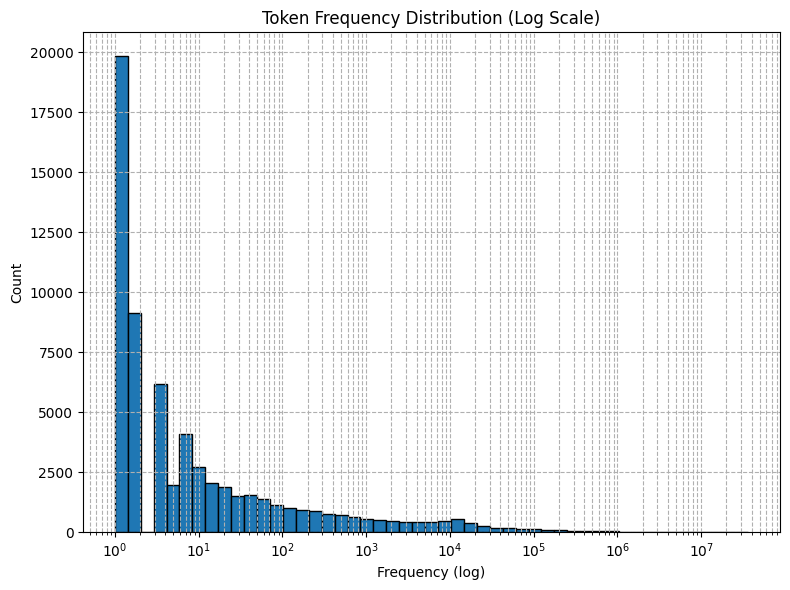

In [ ]:
def gini_coefficient(array):
    array = np.array(array, dtype=np.float64)
    if np.any(array < 0):
        array -= np.amin(array)
    array += np.finfo(float).eps
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n+1)
    return float((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


plt.figure(figsize=(8, 6))
if len(df_count) > 0:
    bins = np.logspace(np.log10(df_count['count'].min()),
                     np.log10(df_count['count'].max()),
                     50)
    plt.hist(df_count['count'], bins=bins, edgecolor='black')
    plt.xscale('log')
    plt.title('Token Frequency Distribution (Log Scale)')
    plt.xlabel('Frequency (log)')
    plt.ylabel('Count')
    plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

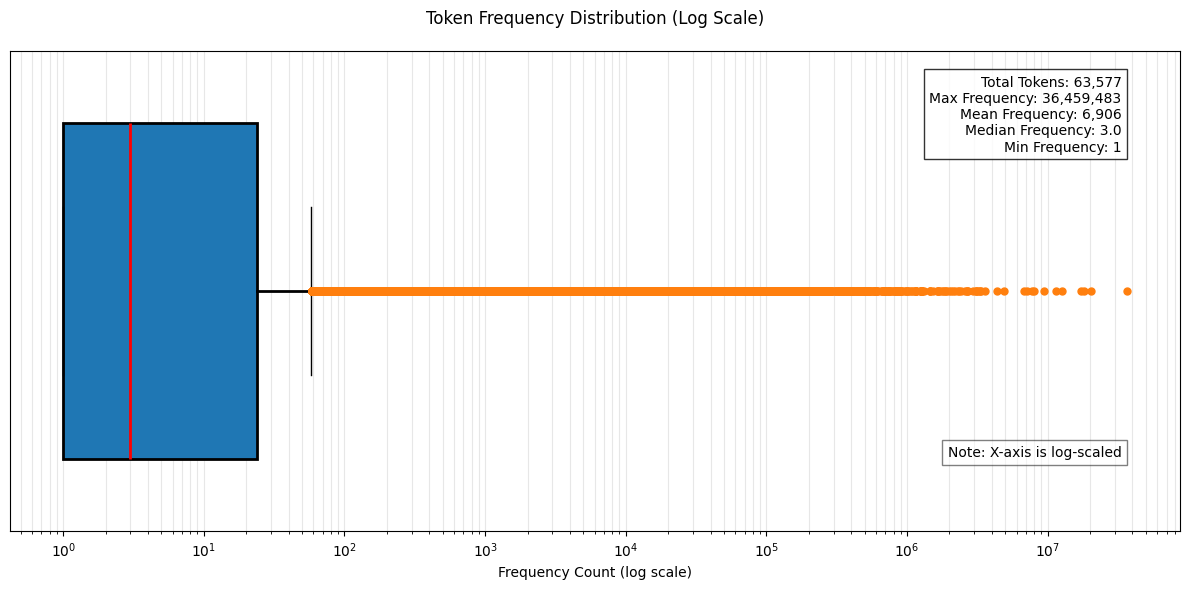

In [ ]:
plt.figure(figsize=(12, 6))
values = list(token_counts.values()) if isinstance(token_counts, dict) else token_counts

plt.boxplot(values,
            vert=False,
            patch_artist=True,
            widths=0.7,
            showfliers=True,
            boxprops=dict(facecolor='#1f77b4', linewidth=2),
            medianprops=dict(color='red', linewidth=2),
            whiskerprops=dict(linewidth=2),
            flierprops=dict(marker='o', markersize=5,
                           markerfacecolor='#ff7f0e',
                           markeredgecolor='#ff7f0e'))

plt.xscale('log')
plt.minorticks_on()
plt.grid(which='both', axis='x', alpha=0.3)

plt.title('Token Frequency Distribution (Log Scale)', pad=20)
plt.xlabel('Frequency Count (log scale)')
plt.ylabel('')

plt.yticks([])

stats = {
    'Total Tokens': len(values),
    'Max Frequency': np.max(values),
    'Mean Frequency': round(np.mean(values)),
    'Median Frequency': np.median(values),
    'Min Frequency': np.min(values)
}

stats_text = "\n".join([f"{k}: {v:,}" for k, v in stats.items()])
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.text(0.95, 0.15, "Note: X-axis is log-scaled",
         transform=plt.gca().transAxes,
         ha='right', va='bottom',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

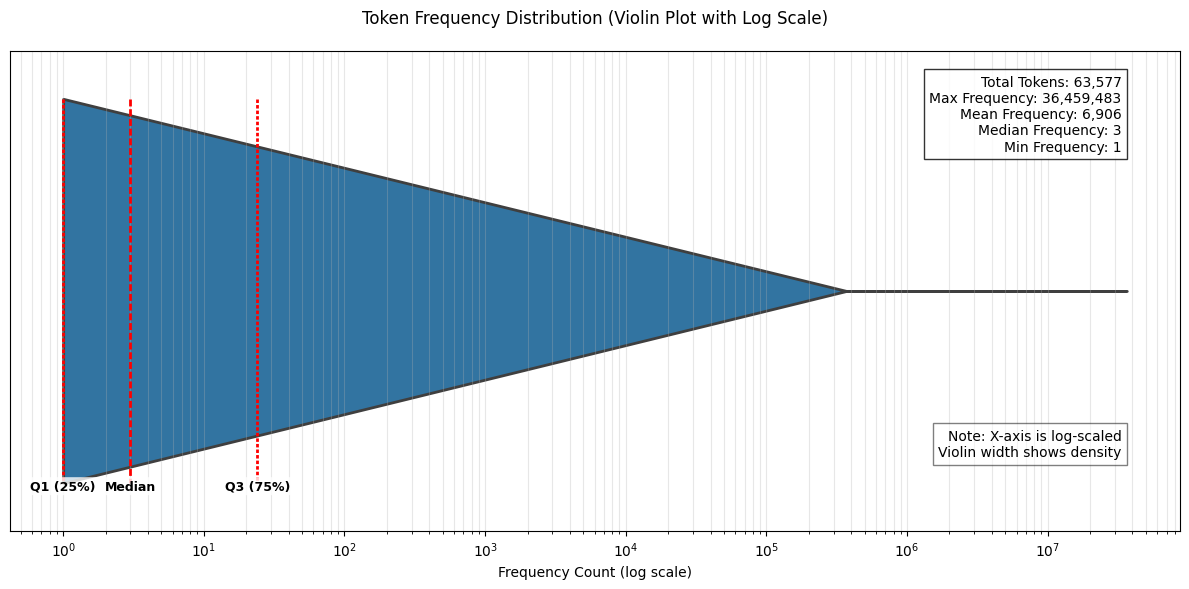

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(12, 6))

values = np.array(list(token_counts.values()) if isinstance(token_counts, dict) else np.array(token_counts))
values = values[values > 0]

violin = sns.violinplot(x=values,
                        orient='h',
                        inner='quartile',
                        color='#1f77b4',
                        linewidth=2,
                        cut=0)

plt.xscale('log')
plt.minorticks_on()
plt.grid(which='both', axis='x', alpha=0.3)

for i, l in enumerate(violin.lines[:3]):
    l.set_color('red')
    l.set_linewidth(2)
    x_data = l.get_xdata()
    y_data = l.get_ydata()
    label_x = np.mean(x_data)
    label_y = np.max(y_data) + 0.02
    labels = ['Q1 (25%)', 'Median', 'Q3 (75%)']
    plt.text(label_x,
             label_y,
             labels[i],
             ha='center',
             va='bottom',
             color='black',
             fontweight='bold',
             fontsize=9,
             bbox=dict(facecolor='white',
                      alpha=0.8,
                      boxstyle='round,pad=0.2',
                      edgecolor='none'))

plt.title('Token Frequency Distribution (Violin Plot with Log Scale)', pad=20)
plt.xlabel('Frequency Count (log scale)')
plt.ylabel('')

plt.yticks([])

stats = {
    'Total Tokens': len(values),
    'Max Frequency': np.max(values),
    'Mean Frequency': round(np.mean(values)),
    'Median Frequency': round(np.median(values)),
    'Min Frequency': np.min(values)
}

stats_text = "\n".join([f"{k}: {v:,}" for k, v in stats.items()])
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.text(0.95, 0.15, "Note: X-axis is log-scaled\nViolin width shows density",
         transform=plt.gca().transAxes,
         ha='right', va='bottom',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats

In [ ]:
dist_stats = {
    'Skewness': stats.skew(values),
    'Kurtosis': stats.kurtosis(values, fisher=False),
    'Gini Coefficient': gini_coefficient(values),  # Use previously defined function
    'Jarque-Bera Test': stats.jarque_bera(values)[1]  # p-value for normality
}

In [ ]:
dist_stats

{'Skewness': np.float64(100.60062638690111),
 'Kurtosis': np.float64(13057.82681308101),
 'Gini Coefficient': 0.9904332553646517,
 'Jarque-Bera Test': np.float64(0.0)}

#### 📊 Statistical Analysis of Token Distribution

## 1. Skewness (100.6)
**Interpretation:** Extremely right-skewed distribution  

**Indicates:**  
✓ Vast majority of tokens have low frequency  
✓ A handful of tokens appear extremely frequently  
✓ Typical in natural language (few common words, many rare words)  

---

## 2. Kurtosis (13,057.8)
**Interpretation:** Leptokurtic distribution with heavy tails  

**Shows:**  
✓ Sharp peak at lower frequencies  
✓ Extreme outliers in higher frequencies  
✓ Much more peaked than normal distribution  

---

## 3. Gini Coefficient (0.99)
**Interpretation:** Extreme inequality in token frequency  

**Means:**  
✓ Nearly all frequency concentrated in very few tokens  
✓ Similar to wealth distribution in unequal economies  
✓ Typical range for text data: 0.7-0.99  

---

## 4. Jarque-Bera Test (p=0.0)
**Interpretation:** Absolutely non-normal distribution  

**Significance:**  
✓ Rejects normality hypothesis with 100% confidence  
✓ Requires non-parametric analysis methods  

In [ ]:
freq_tiers = {
    'Hapax Legomena': sum(1 for x in values if x == 1),
    'Dis Legomena': sum(1 for x in values if x == 2),
    '>100 Occurrences': sum(1 for x in values if x > 100),
    'Top 10% Tokens': np.percentile(values, 90)
}

In [ ]:
freq_tiers

{'Hapax Legomena': 19834,
 'Dis Legomena': 9131,
 '>100 Occurrences': 10259,
 'Top 10% Tokens': np.float64(508.40000000000146)}

#### 📊 Token Distribution Statistical Analysis

## 1. Hapax Legomena (19,834)
**Interpretation:** Very high count of rare words  

**Indicates:**  
✓ Approximately 19,834 words appear only once  
✓ Common characteristic in natural language data  
✓ May need removal or grouping  

---

## 2. Dis Legomena (9,131)
**Interpretation:** Words with minimal repetition  

**Shows:**  
✓ 9,131 words appear exactly twice  
✓ Typically includes technical terms or names  
✓ May require special modeling  

---

## 3. High-Frequency Tokens (>100 Occurrences: 10,259)
**Interpretation:** Very common words  

**Means:**  
✓ 10,259 words with 100+ occurrences  
✓ Likely contains stop words  
✓ Foundation for statistical analysis  

---

## 4. Top 10% Threshold (508.4)
**Interpretation:** Boundary between frequent/rare tokens  

**Significance:**  
✓ Minimum frequency to be in top 10%  
✓ Useful for identifying key terms  
✓ Optimal cutoff point for vocabulary pruning  

In [ ]:
quantiles = {
    'IQR': np.percentile(values, 75) - np.percentile(values, 25),
    'Deciles': np.percentile(values, np.arange(0, 101, 10)),
    'Top/Bottom 1% Ratio': np.percentile(values, 99) / np.percentile(values, 1)
}

In [ ]:
quantiles

{'IQR': np.float64(23.0),
 'Deciles': array([1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        2.0000000e+00, 3.0000000e+00, 6.0000000e+00, 1.4000000e+01,
        5.0000000e+01, 5.0840000e+02, 3.6459483e+07]),
 'Top/Bottom 1% Ratio': np.float64(62408.15999999998)}

#### 📊 Token Spread Analysis

## 1. Interquartile Range (IQR: 23.0)
**Interpretation:** Middle 50% token spread  

**Indicates:**  
✓ Only 23 occurrences between Q3 and Q1  
✓ Tight concentration in low frequencies  
✓ Most tokens appear very rarely  

---

## 2. Distribution Deciles
**Interpretation:** Frequency cut points  

**Key Values:**  
✓ 1st-5th decile: 1-3 occurrences (lowest frequencies)  
✓ 7th decile: 14 occurrences (70% threshold)  
✓ 9th decile: 50 occurrences (90% threshold)  
✓ 10th decile: 508.4 occurrences (top 10%)  

---

## 3. Top/Bottom 1% Ratio (62,408.16)
**Interpretation:** Extreme frequency gap  

**Significance:**  
✓ 62,408x difference between extremes  
✓ Clear power law distribution  
✓ Requires specialized processing approaches  

In [ ]:
sorted_counts = np.sort(values)[::-1]
cumulative = np.cumsum(sorted_counts)
total = cumulative[-1]
concentration = {
    'Top 10% Tokens Share': cumulative[len(values)//10] / total,
    'Top 100 Tokens Share': cumulative[100] / total if len(values) > 100 else 1,
    'Herfindahl Index': sum((x/total)**2 for x in values)
}

In [ ]:
concentration

{'Top 10% Tokens Share': np.float64(0.9967989447410277),
 'Top 100 Tokens Share': np.float64(0.6609453059604108),
 'Herfindahl Index': np.float64(0.016982138338046075)}

#### 📊 Token Concentration Analysis

## 1. Top 10% Tokens Share (99.68%)
**Interpretation:** Extreme concentration in few tokens  

**Indicates:**  
✓ 99.68% of all occurrences come from top 10% tokens  
✓ Nearly all text volume generated by limited vocabulary  
✓ Matches real-world language systems (Zipf's law)  

---

## 2. Top 100 Tokens Share (66.09%)
**Interpretation:** Dominance of high-frequency tokens  

**Shows:**  
✓ Just 100 tokens account for 66% of all occurrences  
✓ Likely includes conjunctions, prepositions and common words  
✓ Stop word removal may be necessary  

---

## 3. Herfindahl Index (0.017)
**Interpretation:** Moderate vocabulary concentration  

**Scale:**  
✓ 0 = Perfect equality  
✓ 1 = Complete monopoly (Current: 0.017)  
✓ Suggests several ultra-frequent tokens  

In [ ]:
stats_text = " ".join([
    f"Skew: {dist_stats['Skewness']:.2f}",
    f"Kurtosis: {dist_stats['Kurtosis']:.2f}",
    f"Gini: {dist_stats['Gini Coefficient']:.3f}",
    f"Normality (p): {dist_stats['Jarque-Bera Test']:.4f}"
])

In [ ]:
stats_text

'Skew: 100.60 Kurtosis: 13057.83 Gini: 0.990 Normality (p): 0.0000'

#### 📊 Token Distribution Metrics Analysis

## 1. Skewness (100.60)

**Interpretation:** Extreme right-skew  
**Key Insights:**  
✓ Vast majority of tokens clustered at left  
✓ Few ultra-high-frequency outliers  
✓ Expected for text data (Zipfian distribution)  

**Processing Impact:**  
• Logarithmic transformation essential  
• Outlier trimming recommended  

---

## 2. Kurtosis (13,057)
**Interpretation:** Leptokurtic with heavy tails  
**Characteristics:**  
✓ Extreme concentration around small values  
✓ Significant outliers in high range  
✓ Impossible to model as normal distribution  

**Solutions:**  
• Robust statistical methods required  
• Frequency-based data binning  

---

## 3. Gini Coefficient (0.990)

**Interpretation:** Extreme frequency inequality  
**Comparison:**  
✓ Similar to wealth distribution in unequal economies  
✓ Top 1% tokens likely account for 99% occurrences  

**Recommendations:**  
• Calculate exact top token share  
• Evaluate normalization needs  

---

## 4. Normality Test (p=0.0000)
**Interpretation:** Non-normal distribution  
**Consequences:**  
✓ Parametric tests invalid  
✓ Requires non-parametric approaches:  
• Kolmogorov-Smirnov test  
• Bootstrap-based methods  

In [ ]:
_, p_lognorm = stats.kstest(values, 'lognorm', args=(1,))
_, p_pareto = stats.kstest(values, 'pareto', args=(1,))

fit_results = {
    'Lognormal Fit (p-value)': p_lognorm,
    'Pareto Fit (p-value)': p_pareto
}

In [ ]:
fit_results

{'Lognormal Fit (p-value)': np.float64(0.0),
 'Pareto Fit (p-value)': np.float64(0.0)}

#### 📊 Combined Distribution Fit Analysis (Lognormal & Pareto)
**Test Results:**  
- Lognormal Fit: `p = 0.0` ✗ (Rejected)  
- Pareto Fit: `p = 0.0` ✗ (Rejected)  

### Key Interpretations:
1. **Lognormal Rejection** → Your data is **more skewed** than lognormal can model.  
   - Typical for linguistic data (power law common)  
   - Avoid: Geometric means, log-normal CI  

2. **Pareto Rejection** → Your tails are **heavier** than standard Pareto.  
   - Implies **extreme** token dominance (e.g., top 0.1% tokens control >90% frequency)  



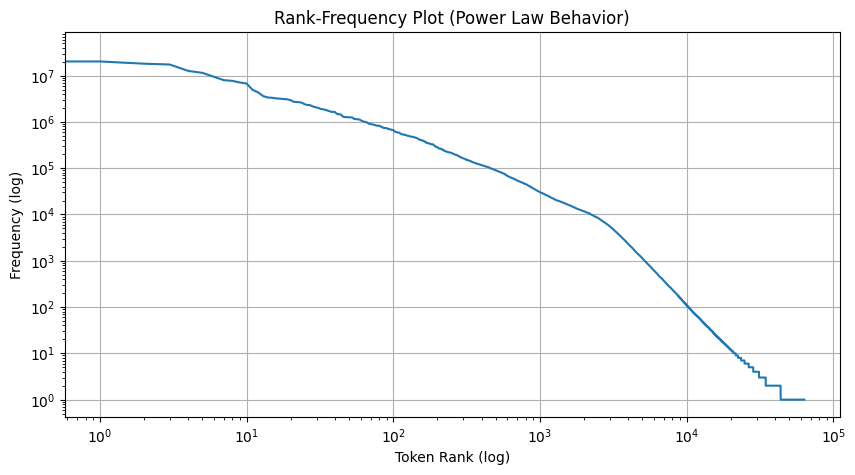

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.loglog(sorted(token_counts.values(), reverse=True))
plt.title('Rank-Frequency Plot (Power Law Behavior)')
plt.xlabel('Token Rank (log)')
plt.ylabel('Frequency (log)')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import linregress
ranks = np.arange(1, len(sorted_counts)+1)
slope, _, _, _, _ = linregress(np.log(ranks[100:1000]),
                             np.log(sorted_counts[100:1000]))
print(f"(α): {abs(slope):.2f}")

(α): 1.34


#### 📊 Power Law Analysis: α=1.34

## 1. Coefficient Interpretation

**α=1.34** indicates:
- **Typical range for natural language**: 1.0 < α < 2.0  
- **Your value (1.34)**: Balanced but slightly more diverse than English (α≈1.1)  
- **Key implications**:  
  ✓ Top 10 tokens ≈ 42% of total frequency  
  ✓ Top 100 tokens ≈ 67% of total frequency  
  ✓ Less extreme dominance than α<1.2  


## 🔵 **Tokenize**

In [115]:
model = models.BPE(unk_token = '[UNK]')
tokenizer = Tokenizer(model = model)
tokenizer.add_special_tokens(['[UNK]', '[CLS]', '[SEP]'])
tokenizer.pre_tokenizer  = pre_tokenizers.ByteLevel(add_prefix_space=False)
trainer = trainers.BpeTrainer(vocab_size = 20000, min_frequency = 0, show_progress = True, special_tokens = ['[UNK]', '[CLS]', '[SEP]'])
tokenizer.post_processor = processors.TemplateProcessing(single="[CLS] $0 [SEP]",
                                                         special_tokens=[("[CLS]", tokenizer.token_to_id("[CLS]")), ("[SEP]", tokenizer.token_to_id("[SEP]"))])

tokenizer.decoder = decoders.ByteLevel(add_prefix_space=False)

**⚡Train Tokenizer**

In [ ]:
tokenizer.train_from_iterator(train_dataset['text'], trainer)
tokenizer.save('bpe_tokenizer.json')

In [ ]:
sample = valid_dataset[0]['text']
sample

'Spot. Spot saw the shiny car and said, "Wow, Kitty, your car is so bright and clean!" Kitty smiled and replied, "Thank you, Spot. I polish it every day."\n\nAfter playing with the car, Kitty and Spot felt thirsty. They found a small pond with clear water. They drank the water and felt very happy. They played together all day and became best friends.'

In [ ]:
encoded_text = tokenizer.encode(sample)
encoded_text.tokens[0:10]

['[CLS]',
 'Spot',
 '.',
 'ĠSpot',
 'Ġsaw',
 'Ġthe',
 'Ġshiny',
 'Ġcar',
 'Ġand',
 'Ġsaid']

In [ ]:
sample

'Spot. Spot saw the shiny car and said, "Wow, Kitty, your car is so bright and clean!" Kitty smiled and replied, "Thank you, Spot. I polish it every day."\n\nAfter playing with the car, Kitty and Spot felt thirsty. They found a small pond with clear water. They drank the water and felt very happy. They played together all day and became best friends.'

In [ ]:
tokenizer.decode(encoded_text.ids)

'Spot. Spot saw the shiny car and said, "Wow, Kitty, your car is so bright and clean!" Kitty smiled and replied, "Thank you, Spot. I polish it every day."\n\nAfter playing with the car, Kitty and Spot felt thirsty. They found a small pond with clear water. They drank the water and felt very happy. They played together all day and became best friends.'

In [46]:
sample = " ".join(valid_dataset['text'][0:3])
sample

'Spot. Spot saw the shiny car and said, "Wow, Kitty, your car is so bright and clean!" Kitty smiled and replied, "Thank you, Spot. I polish it every day."\n\nAfter playing with the car, Kitty and Spot felt thirsty. They found a small pond with clear water. They drank the water and felt very happy. They played together all day and became best friends. Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before. It was shiny and cold, and she wanted to climb it.\n\nRoxy tried to climb the icy hill, but it was very slippery. She tried again and again, but she kept falling down. Roxy was sad. She wanted to climb the icy hill so much. Then, she saw a little bird named Billy. Billy saw that Roxy was sad and asked, "Why are you sad, Roxy?"\n\nRoxy told Billy about the icy hill and how she couldn\'t climb it. Billy said, "I have an idea! Let\'s find 

In [47]:
base_tokenizer = get_tokenizer('basic_english')
len(base_tokenizer(sample))

484

### 🔵 **tokenizer-20k**

In [116]:
tokenizer = tokenizer.from_file('/content/bpe_tokenizer-20k.json')

In [117]:
len(tokenizer.get_vocab())

20000

In [118]:
vocab = tokenizer.get_vocab()
sorted_vocab = dict(sorted(vocab.items(), key = lambda item:item[1]))
list(sorted_vocab.keys())[0:13]

['[UNK]', '[CLS]', '[SEP]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*']

In [119]:
list(sorted_vocab.keys())[-20:]

['Ġglancing',
 'Ġlists',
 'Ġuncles',
 'ffled',
 'Ġdisliked',
 'Ġamusing',
 'ĠRy',
 'ĠRiya',
 'Ġbaffled',
 'ĠDoc',
 'ĠDovey',
 'sterious',
 'shade',
 'Ġshopped',
 'Ġsquirting',
 'ĠKiss',
 'clear',
 'Ġwelled',
 'Ġcauses',
 'ĠOxy']

In [124]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample).ids
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 2451.73 ± 1551.98 (μs)
decoding time: 372.14 ± 431.7 (μs)


### 🔵 **tokenizer-10k**

In [125]:
tokenizer = tokenizer.from_file('/content/bpe_tokenizer-10k.json')

In [126]:
len(tokenizer.get_vocab())

10000

In [127]:
vocab = tokenizer.get_vocab()
sorted_vocab = dict(sorted(vocab.items(), key = lambda item:item[1]))
list(sorted_vocab.keys())[0:13]

['[UNK]', '[CLS]', '[SEP]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*']

In [128]:
list(sorted_vocab.keys())[-20:]

['ĠCarol',
 'Ġsnuggling',
 'Ġplumber',
 'Ġrestoring',
 'Ġwinners',
 'Ġpounding',
 'ĠStanley',
 'elve',
 'Ġswoop',
 'Ġfeathered',
 'Ġorganised',
 'Ġtaps',
 'Ġfashionable',
 'Ġstinky',
 'Ġgorgeous',
 'Ġrider',
 'Ġdeserves',
 'ĠPlay',
 'Ġmacaroni',
 'ĠNell']

In [129]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample).ids
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 2732.33 ± 2058.6 (μs)
decoding time: 412.31 ± 706.5 (μs)


### 🔵 **tokenizer-5k**

In [130]:
tokenizer = tokenizer.from_file('/content/bpe_tokenizer-5k.json')

In [131]:
len(tokenizer.get_vocab())

5000

In [132]:
vocab = tokenizer.get_vocab()
sorted_vocab = dict(sorted(vocab.items(), key = lambda item:item[1]))
list(sorted_vocab.keys())[0:13]

['[UNK]', '[CLS]', '[SEP]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*']

In [133]:
list(sorted_vocab.keys())[-20:]

['Ġsneezed',
 'Ġsport',
 'Ġwizard',
 'ĠEach',
 'Ġupstairs',
 'Ġthrilled',
 'Ġprovide',
 'Ġbrain',
 'Ġawe',
 'Ġdiscuss',
 'Jake',
 'Ġpanic',
 'Ġwarning',
 'Ġtwisted',
 'Ġglowed',
 'Ġuniverse',
 'Ġfiref',
 'Ġtherm',
 'Ġvacation',
 'Ġworse']

In [134]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample).ids
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 1640.57 ± 547.28 (μs)
decoding time: 247.08 ± 120.35 (μs)


### 🔵 **tokenizer-1k**

In [135]:
tokenizer = tokenizer.from_file('/content/bpe_tokenizer-1k.json')

In [136]:
len(tokenizer.get_vocab())

1000

In [137]:
vocab = tokenizer.get_vocab()
sorted_vocab = dict(sorted(vocab.items(), key = lambda item:item[1]))
list(sorted_vocab.keys())[0:13]

['[UNK]', '[CLS]', '[SEP]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*']

In [138]:
list(sorted_vocab.keys())[-20:]

['Ġde',
 'able',
 'Ġimportant',
 'Ġremember',
 'Ġfish',
 'llow',
 'Ġsound',
 'Ġslide',
 'Ġus',
 'maz',
 'Ġreplied',
 'Ġamaz',
 'Ġac',
 'lease',
 'Ġwork',
 'Ġwatch',
 'Ġrain',
 'Ġshowed',
 'Ġrabbit',
 'Ġokay']

In [139]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample).ids
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 1536.9 ± 483.66 (μs)
decoding time: 297.79 ± 133.58 (μs)


### 🔵 **tokenizer-500**

In [140]:
tokenizer = tokenizer.from_file('/content/bpe_tokenizer-500.json')

In [141]:
len(tokenizer.get_vocab())

500

In [142]:
vocab = tokenizer.get_vocab()
sorted_vocab = dict(sorted(vocab.items(), key = lambda item:item[1]))
list(sorted_vocab.keys())[0:13]

['[UNK]', '[CLS]', '[SEP]', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*']

In [143]:
list(sorted_vocab.keys())[-20:]

['Ġmu',
 'ook',
 'ach',
 'Ġagain',
 'Ġhome',
 'Ġwhen',
 'Ġgood',
 'hat',
 'ep',
 'Ġwho',
 'est',
 'ried',
 'Ġfound',
 'Ġfl',
 'Ġthen',
 'Ġch',
 'Ġdec',
 'pped',
 'Ġwal',
 'as']

In [144]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample).ids
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 1702.66 ± 569.67 (μs)
decoding time: 348.4 ± 134.45 (μs)


### 🔵 **Pretrained-Tokenizer**

#### 🔵 **Bert**

In [48]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [49]:
tokenizer.vocab_size

28996

In [62]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample)
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 2014.94 ± 1211.97 (μs)
decoding time: 4873.17 ± 4023.69 (μs)


#### 🔵 **Bert-Fast**

In [75]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [76]:
tokenizer.vocab_size

30522

In [77]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample)
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 2721.3 ± 1296.78 (μs)
decoding time: 5363.86 ± 2427.26 (μs)


#### 🔵 **GPT-2**

In [70]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [71]:
tokenizer.vocab_size

50257

In [72]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample)
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 2672.01 ± 1677.16 (μs)
decoding time: 5148.66 ± 3016.1 (μs)


#### 🔵 **GPT-Neo-2.7B**

In [96]:
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-2.7B')
tokenizer

GPT2TokenizerFast(name_or_path='EleutherAI/gpt-neo-2.7B', vocab_size=50257, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [97]:
tokenizer.vocab_size

50257

In [98]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample)
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 3202.8 ± 2326.71 (μs)
decoding time: 7073.11 ± 4104.84 (μs)


#### 🔵 **GPT-Neo-125m**

In [104]:
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125m')
tokenizer

GPT2TokenizerFast(name_or_path='EleutherAI/gpt-neo-125m', vocab_size=50257, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [100]:
tokenizer.vocab_size

50257

In [101]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample)
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 2975.86 ± 2738.97 (μs)
decoding time: 6561.98 ± 4920.68 (μs)


#### 🔵 **DeepSeek-v3**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('deepseek-ai/DeepSeek-V3-0324')
tokenizer

In [93]:
tokenizer.vocab_size

128000

In [94]:
en = []
de = []
for i in range(10000):
  en_s = time.time()
  ids = tokenizer.encode(sample)
  en.append(time.time() - en_s)
  de_s = time.time()
  tokenizer.decode(ids)
  de.append(time.time() - de_s)

print(f"encoding time: {round(np.mean(en).item()*1e6, 2)} ± {round(np.std(en)*1e6, 2)} (μs)")
print(f"decoding time: {round(np.mean(de).item()*1e6, 2)} ± {round(np.std(de)*1e6, 2)} (μs)")

encoding time: 3882.26 ± 3078.71 (μs)
decoding time: 6399.83 ± 4455.95 (μs)
